<a href="https://colab.research.google.com/github/easonchiu0327/Module3.1/blob/main/FinalProject_ANLT202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Clone the GitHub Repo into Colab

!git clone https://github.com/Andres-lng/ML-DL-FINALPROJECT.git

Cloning into 'ML-DL-FINALPROJECT'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 87 (delta 37), reused 23 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 2.54 MiB | 13.20 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [2]:
# Install libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import urllib.request


# The larger one (churn-bigml-80.csv, 2666 rows) for training and cross-validation,
# The smaller one (churn-bigml-20.csv, 667 rows) for final testing/evaluation.
# No need for additional splitting.

df_train = pd.read_csv('ML-DL-FINALPROJECT/data/churn-bigml-80.csv')
df_test  = pd.read_csv('ML-DL-FINALPROJECT/data/churn-bigml-20.csv')

print(df_train.shape, df_test.shape)

# DATA EXPLORATION & PREPROCESSING
df_train.info()
df_test.info()

# handling missing values
print(df_train.isnull().sum().sum(), df_test.isnull().sum().sum())

# check imbalance
print("Imbalance checking:")
print(df_train['Churn'].value_counts())
print(df_test['Churn'].value_counts())

# Compute total_monthly_charge for CLV calculation (Simulated)
df_train['total_monthly_charge'] = (df_train['Total day charge'] + df_train['Total eve charge'] +
                                    df_train['Total night charge'] + df_train['Total intl charge'])
df_test['total_monthly_charge'] = (df_test['Total day charge'] + df_test['Total eve charge'] +
                                   df_test['Total night charge'] + df_test['Total intl charge'])

charge_cols_to_drop = ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']
minutes_cols_to_drop = ['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']

# Map Churn to 0/1
df_train['Churn'] = df_train['Churn'].astype(int)
df_test['Churn'] = df_test['Churn'].astype(int)

# CLV CALCULATION (SIMULATED)
# Estimate CLV based on known customer tenure, total bill, and plan indicators.
# CLV = (Account Length * Base) + (Total Charge * Multiplier) + (Plan Bonuses) + Noise
base_value = 100
charge_multiplier = 35

#Calculate a simulated Estimated CLV
def calculate_clv(df):
    clv_base = (
        (df['Account length'] * base_value) +
        (df['total_monthly_charge'] * charge_multiplier) +
        (df['International plan'].apply(lambda x: 1 if x == 'yes' else 0) * 500) +
        (df['Voice mail plan'].apply(lambda x: 1 if x == 'yes' else 0) * 300)
    )
    # Add noise and ensure CLV is positive (measured in currency)
    return np.maximum(clv_base + np.random.normal(0, 1000, len(df)), 50)

df_train['Estimated_CLV'] = calculate_clv(df_train)
df_test['Estimated_CLV'] = calculate_clv(df_test)

print(f"CLV Target created. Mean Estimated CLV (Train): ${df_train['Estimated_CLV'].mean():,.2f}")

# Features and targets
# Columns to exclude from features: targets, derived values that are part of the target (target leakage)
cols_to_exclude = (
    ['Churn', 'Estimated_CLV', 'total_monthly_charge'] +
    charge_cols_to_drop +
    minutes_cols_to_drop
)
X_train = df_train.drop(cols_to_exclude, axis=1, errors='ignore')
y_clf_train = df_train['Churn']
y_reg_train = df_train['Estimated_CLV']

X_test = df_test.drop(cols_to_exclude, axis=1, errors='ignore')
y_clf_test = df_test['Churn']
y_reg_test = df_test['Estimated_CLV']


# Treat Area code as categorical
X_train['Area code'] = X_train['Area code'].astype(str)
X_test['Area code'] = X_test['Area code'].astype(str)

# Categorical and numerical columns
cat_cols = ['State', 'Area code', 'International plan', 'Voice mail plan']
num_cols = [col for col in X_train.columns if col not in cat_cols]

print("Categorical:", cat_cols)
print("Numerical:", num_cols)

# Outliers check (no handling needed, values reasonable)
print(X_train[num_cols].describe())

# 3. PREPROCESSING PIPELINE SETUP
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])


(2666, 20) (667, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge 

**BUSINESS PROBLEM DEFINITION**

Classification Task : Predict 'Churn' (True/False)


*   Business Impact: Reducing churn by 1% can increase profit by millions
*   Early identification : targeted retention campaigns



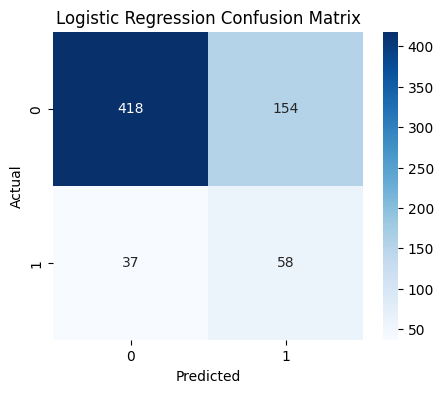

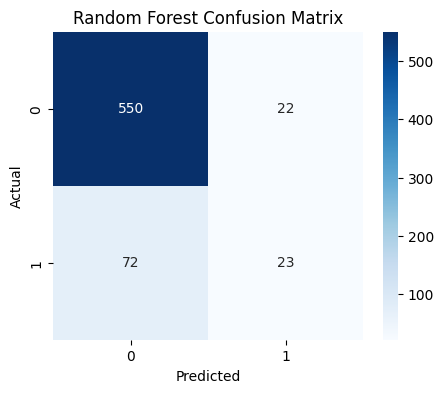


Logistic Regression
Accuracy: 0.7136431784107946
Precision: 0.27358490566037735
Recall: 0.6105263157894737
F1 Score: 0.3778501628664495

Random Forest
Accuracy: 0.8590704647676162
Precision: 0.5111111111111111
Recall: 0.24210526315789474
F1 Score: 0.32857142857142857
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': 20}

Tuned Random Forest
Accuracy: 0.8665667166416792
Precision: 0.5517241379310345
Recall: 0.3368421052631579
F1 Score: 0.41830065359477125


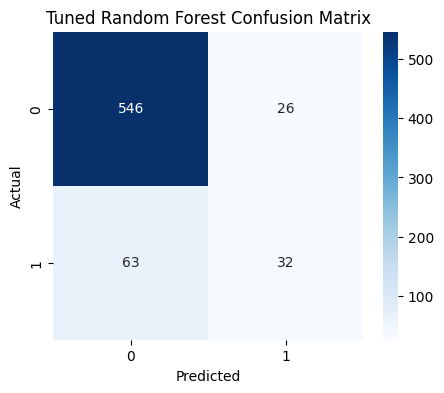


Pipeline Logistic Regression
Accuracy: 0.7136431784107946
Precision: 0.27358490566037735
Recall: 0.6105263157894737
F1 Score: 0.3778501628664495


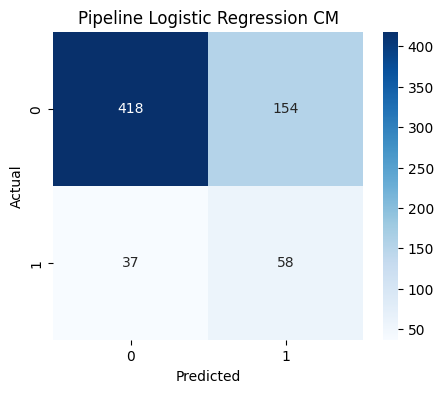

In [ ]:
# Classification Models
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

logreg_clf = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])

logreg_clf.fit(X_train, y_clf_train)
logreg_pred = logreg_clf.predict(X_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=300, random_state=42))
])

rf_clf.fit(X_train, y_clf_train)
rf_pred = rf_clf.predict(X_test)

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_scores(name, y_true, y_pred):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_cm(y_clf_test, logreg_pred, "Logistic Regression Confusion Matrix")
plot_cm(y_clf_test, rf_pred, "Random Forest Confusion Matrix")

# Print results
print_scores("Logistic Regression", y_clf_test, logreg_pred)
print_scores("Random Forest", y_clf_test, rf_pred)

from sklearn.model_selection import RandomizedSearchCV

# Search space for Random Forest
param_grid = {
    'model__n_estimators': [200, 300, 400, 500, 600],
    'model__max_depth': [None, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Pipeline
rf_tune = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

# RandomizedSearchCV:
#   - Faster than GridSearch
#   - Explores random combinations
#   - Optimizes F1 score
search = RandomizedSearchCV(
    rf_tune,
    param_grid,
    n_iter=10,          # number of random searches
    scoring='f1',       # F1 is better for churn balance
    cv=3,               # 3-fold cross-validation
    n_jobs=-1,          # use all CPU cores
    random_state=42,
    verbose=1
)

# Fit tuning using train/validation split
search.fit(X_train, y_clf_train)

# Extract best model and evaluate it
best_rf = search.best_estimator_
tuned_pred = best_rf.predict(X_test)

print("Best Parameters:", search.best_params_)
print_scores("Tuned Random Forest", y_clf_test, tuned_pred)
plot_cm(y_clf_test, tuned_pred, "Tuned Random Forest Confusion Matrix")


clf_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit on the internal training split
clf_pipeline.fit(X_train, y_clf_train)

# Predict on validation set
pipeline_pred = clf_pipeline.predict(X_test)

# Show results
print_scores("Pipeline Logistic Regression", y_clf_test, pipeline_pred)
plot_cm(y_clf_test, pipeline_pred, "Pipeline Logistic Regression CM")

**BUSINESS PROBLEM DEFINITION**

Regression Task : Predict Customer Lifetime Value


*   Business Impact: Predicting CLV provides foundational data that supports critical strategic and operational functions across multiple departments.

In [ ]:
# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Linear Regression
lin_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lin_reg_pipeline.fit(X_train, y_reg_train)
y_pred_lin_reg = lin_reg_pipeline.predict(X_test)

# Gradient Boosting Regressor (GBR)
gbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
gbr_pipeline.fit(X_train, y_reg_train)
y_pred_gbr_untuned = gbr_pipeline.predict(X_test)

def print_regression_report(name, y_true, y_pred):
    print(f"\n{name}")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R²   : {r2_score(y_true, y_pred):.4f}")

print_regression_report("Linear Regression", y_reg_test, y_pred_lin_reg)
print_regression_report("Gradient Boosting Regressor", y_reg_test, y_pred_gbr_untuned)

# Hyperparameter Tuning (GridSearchCV for GBR)
# Define parameter grid for tuning GBR
param_grid = {
    'regressor__n_estimators': [100, 200], # Number of trees
    'regressor__max_depth': [3, 5],       # Depth of trees
    'regressor__learning_rate': [0.05, 0.1]
}

grid_search = GridSearchCV(
    gbr_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_reg_train)
print("Best Regressor Params:", grid_search.best_params_)

# Tuned Gradient Boosting Regressor (GBR)
best_gbr = grid_search.best_estimator_
y_pred_gbr_tuned = best_gbr.predict(X_test)

print_regression_report("Tuned Gradient Boosting Regressor", y_reg_test, y_pred_gbr_tuned)


Linear Regression
MAE  : 852.4834
RMSE : 1085.3269
R²   : 0.9343

Gradient Boosting Regressor
MAE  : 864.3376
RMSE : 1095.7049
R²   : 0.9330
Best Regressor Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}

Tuned Gradient Boosting Regressor
MAE  : 863.9782
RMSE : 1092.3571
R²   : 0.9334


Epoch 1/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6899 - loss: 0.7025 - val_accuracy: 0.5022 - val_loss: 0.6914
Epoch 2/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6116 - loss: 0.6213 - val_accuracy: 0.6027 - val_loss: 0.6732
Epoch 3/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6869 - loss: 0.5959 - val_accuracy: 0.6162 - val_loss: 0.6791
Epoch 4/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6867 - loss: 0.5662 - val_accuracy: 0.7391 - val_loss: 0.5534
Epoch 5/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7563 - loss: 0.5392 - val_accuracy: 0.7136 - val_loss: 0.5827
Epoch 6/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7673 - loss: 0.5147 - val_accuracy: 0.7046 - val_loss: 0.6137
Epoch 7/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7499 - loss: 0.5371 - val_accuracy: 0.7286 - val_loss: 0.5588
Epoch 8/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7503 - loss: 0.4920 - val_accuracy: 0.7241 - val_loss

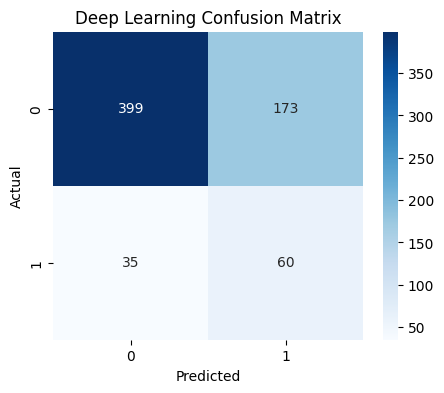

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 162090176.0000 - mae: 12048.4365 - val_loss: 166316064.0000 - val_mae: 12190.7305
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 154542896.0000 - mae: 11719.5322 - val_loss: 85973216.0000 - val_mae: 8622.2930
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 49650456.0000 - mae: 6129.3330 - val_loss: 5717748.5000 - val_mae: 1865.8326
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5778972.0000 - mae: 1895.7495 - val_loss: 4328591.0000 - val_mae: 1615.2837
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4695666.5000 - mae: 1705.8879 - val_loss: 3790994.5000 - val_mae: 1531.6545
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4136365.7500 - mae: 1612.4810 - val_loss: 3386982.7500 - val_mae: 1463.2043
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3735349.0000 - mae: 1518.4313 - val_loss: 3026873.2500 - val_mae: 1364.9410
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5

In [ ]:
#Deep Learning Models
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Fit the preprocessor ONLY on training data, then transform both sets.
X_train_dl = preprocessor.fit_transform(X_train)
X_test_dl = preprocessor.transform(X_test)

input_shape = X_train_dl.shape[1]

# Calculate the inverse class frequency weights
classes = np.unique(y_clf_train)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes,  y=y_clf_train)

# Convert to dictionary format required by Keras/TensorFlow
class_weight_dict = dict(zip(classes, class_weights_array))

# Build a simple feedforward neural network for Churn
churn_dnn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_dl.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
churn_dnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Monitor validation loss, and stop if no improvement for 10 epochs.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1 # Show when training stops
)

# Train the model
# Increased verbosity to monitor training
history = churn_dnn_model.fit(
    X_train_dl, y_clf_train,
    validation_data=(X_test_dl, y_clf_test),
    epochs=25,
    batch_size=32,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Convert probability outputs into class labels (0 or 1)
dl_pred_prob = churn_dnn_model.predict(X_test_dl).flatten()
dl_pred = (dl_pred_prob > 0.3).astype(int)

# Evaluate and plot confusion matrix
print_scores("Deep Learning Churn Model", y_clf_test, dl_pred)
plot_cm(y_clf_test, dl_pred, "Deep Learning Confusion Matrix")

# Define the Keras model architecture for CLV
def create_dnn_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=[input_shape]),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer='adam',
                  loss='mse', # Mean Squared Error
                  metrics=['mae'])
    return model

clv_dnn_model = create_dnn_model(input_shape)

# Train the model
history2 = clv_dnn_model.fit(
    X_train_dl, y_reg_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_data=(X_test_dl, y_reg_test),
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred_dnn = clv_dnn_model.predict(X_test_dl).flatten()
print_regression_report("Deep Learning CLV Model", y_reg_test, y_pred_dnn)